# Motivation

The purpose of this notebook is to introduce a simpler method but with the same results or similar to extract the 98 TFs

In [9]:
%load_ext autoreload
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import os
import sys

import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import matplotlib.pyplot as plt

import multiprocess as mp


# own libraries
sys.path.append('/Users/vlad/Developer/York/iNet_v2/src/')

from NetworkAnalysis.ExperimentSet import ExperimentSet
from NetworkAnalysis import GraphHelper as gh
from NetworkAnalysis.utilities import clustering as cs
from NetworkAnalysis.utilities import sankey_consensus_plot as sky
from NetworkAnalysis.utilities.helpers import save_fig, survival_plot
from NetworkAnalysis.GraphToolExp import GraphToolExperiment as GtExp
from NetworkAnalysis.dea import dea
from NetworkAnalysis.dea import helpers as dea_hp
from NetworkAnalysis.dea import gsea as gsea_hp
# Gsea libraries

pio.templates.default = "ggplot2"

pool = mp.Pool(mp.cpu_count())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
results_path = "../../results/exp/"
data_base = "../../data/"
base_path = "../../results/"
exp_folder_tumour = "network_I/tum/"  # "/integration_v2.1/ - path from iNET


# Experiments set
exp_folder_tumour = "network_I/gc_47/tum/"  # "/integration_v2.1/tum/" - path from iNET
exp_folder_h47_ctrl = '../results/network_I/gc_47/tum_ctrls/'


figures_path = "./tum_sel_pruning/"

vu_net_1 = pd.read_csv(f"{data_base}/net_I/vu_net_1.tsv", sep="\t", index_col="Sample")
vu_output = pd.read_csv(f"{data_base}/metadata/VU_clustering_v3.tsv", sep="\t", index_col="Sample")

# Net I labels
vu_output["Net_I"] = vu_net_1["dendrogram_label"]
vu_output["Net_I"] = vu_output["Net_I"].fillna("Na")

tcga_mutations_df = pd.read_csv(f"{data_base}/tumour/mutations_tcga.csv")
tcga_mutations_df = tcga_mutations_df[tcga_mutations_df["count"] != 0].set_index("gene")

tum_tpms = pd.read_csv(f"{data_base}/tumour/TPMs_selected_genes_v3_13k_gc42.tsv", sep="\t", index_col="genes")
tum_tpms_v4 = pd.read_csv(f"{data_base}/tumour/tum_TPMs_selected_genes_gc42_all_v4.tsv", sep="\t", index_col="genes")

# Healthy and metadata
# healthy_metadata = pd.read_csv(f"{data_base}/non_cancerous/healthy_bladder_metadata.tsv", sep="\t", index_col="Sample").drop(index=["Y2796_P0"])
# healthy_metadata["sample_prcsd"] = healthy_metadata.index.str.replace("-", "_")

healthy_tpm = pd.read_csv(f"{data_base}/non_cancerous/healthy_data_all_gc42_v4.tsv", sep="\t", index_col="gene")
remap_col = {}
for col in healthy_tpm.columns:
    remap_col[col] = col.replace("-", "_")
healthy_tpm = healthy_tpm.rename(columns=remap_col)

# tf list
tf_path = f"{data_base}/metadata/TF_names_v_1.01.txt"
if os.path.exists(tf_path):
    tf_list = np.genfromtxt(fname=tf_path, delimiter="\t", skip_header=1, dtype="str")

In [11]:
# Base-line, this is the results from previous work
h_sel_tfs = pd.read_csv(f"{data_base}/tf_ctrl_v2.tsv", index_col="gene", sep="\t")
h_sel_tfs["tum_mean_expression"] = tum_tpms_v4.loc[h_sel_tfs.index].mean(axis=1)
h_sel_tfs["tum_median_expression"] = tum_tpms_v4.loc[h_sel_tfs.index].median(axis=1)
h_sel_tfs["tum_std_expression"] = tum_tpms_v4.loc[h_sel_tfs.index].std(axis=1)
h_sel_tfs["tum_var_expression"] = tum_tpms_v4.loc[h_sel_tfs.index].var(axis=1)

# Tum
t_sel_tfs = pd.read_csv(f"{data_base}/tum_tf_ctrl_1.tsv", index_col="gene", sep="\t")
t_sel_tfs["tum_mean_expression"] = tum_tpms_v4.loc[t_sel_tfs.index].mean(axis=1)
t_sel_tfs["tum_median_expression"] = tum_tpms_v4.loc[t_sel_tfs.index].median(axis=1)
t_sel_tfs["tum_std_expression"] = tum_tpms_v4.loc[t_sel_tfs.index].std(axis=1)
t_sel_tfs["tum_var_expression"] = tum_tpms_v4.loc[t_sel_tfs.index].var(axis=1)

## Import the data

## Experiment sets

In [12]:
def load_experiment_set(base_path, exp_folder_path):
    exp_path = f"{base_path}/{exp_folder_path}/Stats/"
    meta_files = next(os.walk(exp_path), (None, None, []))[2]
    # keep only the network stats
    files = [file for file in meta_files if "networkStats" in file]
    exp_set = {}
    for file in files:
        exp = file.replace(".tsv", "").replace("networkStats_tum_standard_", "")
        exp_set[exp] = pd.read_csv(f"{exp_path}/{file}", index_col="gene", sep="\t")
    return exp_set

In [13]:
folders = next(os.walk(base_path + exp_folder_h47_ctrl), (None, None, []))[1]
exp_ctrls = {}
for folder in folders:
    hCtrl_path = f"/{exp_folder_h47_ctrl}/{folder}/"
    meta_files = next(os.walk(hCtrl_path), (None, None, []))[2]
    # keep only the network stats
    files = [file for file in meta_files if "networkStats" in file]
    exp_ctrls[folder] = load_experiment_set(base_path, hCtrl_path)


exp_set = load_experiment_set(base_path, exp_folder_tumour)

## Network stats

Information calculated in the selective edge pruning

In [14]:
def merge_metrics(exp_set: dict, exp_type: str):
    comb_df = pd.DataFrame()
    for key, metrics in exp_set.items():
        metrics["TF"] = int(key.split("_")[-1].replace("TF", ""))
        metrics["Type"] = exp_type
        comb_df = pd.concat([comb_df, metrics], axis=0)

    return comb_df


# Experiments
all_exps = merge_metrics(exp_set=exp_set, exp_type="Exp")
all_exps["isCtrl"] = False

# Ctrls
all_ctrls = pd.DataFrame()
for key, value in exp_ctrls.items():
    label = key.split("h")[-1]
    ctrl_exps = merge_metrics(exp_set=value, exp_type=key)
    ctrl_exps["isCtrl"] = True
    all_ctrls = pd.concat([all_ctrls, ctrl_exps], axis=0)

# Combined
comb_exps = pd.concat([all_exps, all_ctrls], axis=0)


sel_tfs_metrics = comb_exps.loc[comb_exps.index.isin(t_sel_tfs.index)].copy(deep=True)
# sel_tfs_metrics = comb_exps

reorder_cols = [
    "degree_w",
    "degree_t",
    "degree_i",
    "degree_o",
    "pageRank",
    "closeness",
    "katz",
    "hits",
    "central_point_dominance",
    "max_b",
    "TF",
    "betweenness",
    "marked_as_tf",
    "mut_count",
    "Type",
    "isCtrl",
    "ModCon_Rank",
]
sel_tfs_metrics = sel_tfs_metrics[reorder_cols]
comb_exps = comb_exps[reorder_cols]

# Correlations between the metrics

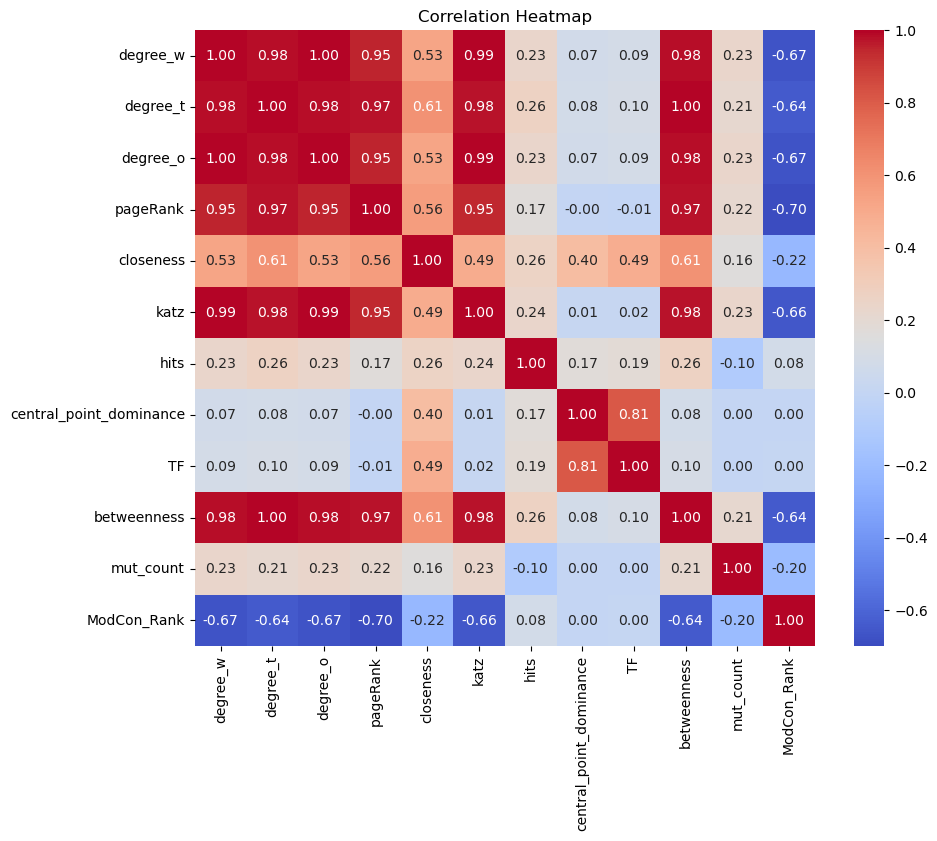

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_df = sel_tfs_metrics.drop(
    columns=[
        "Type",
        "isCtrl",
        "degree_i",
        "marked_as_tf",
        "max_b",
    ]
).corr(method="spearman")

plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap")

plt.savefig(f"{figures_path}/sel_tfs_corr_heatmap.png")

plt.show()

# Matching with the 98 TFs

## Experiment networks

In [16]:
# We want to sort by the order of TF, but first we have to extract the TF values
def sort_exp_set(exp_set: dict):
    sorted_tf = {}
    for key in exp_set.keys():
        prscsd_label = int(key.split("_")[-1].replace("TF", ""))
        sorted_tf[prscsd_label] = key
    sorted_tf = dict(sorted(sorted_tf.items()))

    # Now we can sort the experiment set
    sorted_exp = {}
    for key in sorted_tf.values():
        sorted_exp[key] = exp_set[key]

    return sorted_exp


def calculate_degree_thresholds(exp_set: dict, sel_tfs: pd.DataFrame, label: str, q_th=0.75, verbose=False):

    sel_tfs_set = set()
    if not sel_tfs.empty:
        sel_tfs_set = set(sel_tfs.index)

    top_genes = set()  # genes that are the top set quartile th
    meta_info = []  # meta info about the TF experiments, the genes matched and the evolution across the experiments

    for exp, metrics in exp_set.items():
        deg_th = metrics["degree_t"].quantile(q=q_th)
        genes = set(metrics[metrics["degree_t"] >= deg_th].index)
        tf_exp = int(exp.split("_")[-1].replace("TF", ""))

        # Genes matched, and uniqued to this TF experiment
        single_exp_matched = set(genes) & sel_tfs_set
        unique = single_exp_matched - (top_genes & sel_tfs_set)

        # Add the new genes
        top_genes.update(genes)

        meta_info.append((tf_exp, deg_th, len(genes), len(unique), len(single_exp_matched), list(genes), list(unique), single_exp_matched))

    if sel_tfs.empty:
        matched = top_genes
    else:
        matched = top_genes & set(sel_tfs.index)

    if verbose:
        print(f"--> {label}\n\tQ_th: {q_th}. Matched genes with 98 TFs {len(matched)}. Selected {len(top_genes)}")

    # Combine in a DataFrame
    dmy = pd.DataFrame(meta_info, columns=["TF", "Degree_th", "selected", "unique", "matched", "selected genes", "unique genes", "matched genes"])
    dmy = dmy.sort_values(by=["TF"], ascending=True)
    dmy["TF"] = dmy["TF"].astype(str)
    # If experiment or control
    dmy["type"] = label

    # global stats
    global_stats = {"matched": len(matched), "selected": len(top_genes), "matched_genes": list(matched), "selected_genes": list(top_genes)}
    fig = px.bar(dmy, x="TF", y=["matched", "unique", "selected"], text_auto=True, barmode="group", title=f"Q_th: {q_th}. For {label}")

    # Unselect the 'selected' trace in the plotly figure
    fig.for_each_trace(lambda trace: trace.update(visible="legendonly") if trace.name == "selected" else ())

    return matched, fig, dmy, global_stats

In [17]:
q_ths = list(range(50, 100, 5))
q_ths.sort()
stats = [(0, len(t_sel_tfs))]  # default values
exp_results_qth = pd.DataFrame()
for q_th in q_ths:
    q_th = q_th / 100
    matched_exp, fig_exp, meta_info, global_stats = calculate_degree_thresholds(exp_set=exp_set, sel_tfs=t_sel_tfs, label="Exp", q_th=q_th, verbose=False)
    meta_info["Quantile"] = q_th
    exp_results_qth = pd.concat([exp_results_qth, meta_info], axis=0)

In [18]:
fig = px.line(
    exp_results_qth,
    x="TF",
    y="matched",
    color="Quantile",
    markers=True,
    color_discrete_sequence=px.colors.qualitative.G10,
    title="Inclusion of the 98 TFs genes",
)
fig = fig.update_layout(
    legend=dict(
        orientation="h",
        yanchor="bottom",
        xanchor="center",
        x=0.6,
        y=0.02,
        bgcolor="rgba(0,0,0,0)",
        font=dict(size=20, color="#003366"),
    ),
    xaxis=dict(tickfont=dict(size=20)),
    yaxis=dict(tickfont=dict(size=20), title="Number of 98 TFs included"),
    font=dict(size=20),
)
save_fig(name="exps_98_tfs", fig=fig, base_path=figures_path, width=1800, height=800, margin=0.06)

In [19]:
stats_quantile = exp_results_qth.groupby("Quantile")["Degree_th"].agg(["mean", "std"]).reset_index()
fig = px.line(stats_quantile, x="Quantile", y="mean", error_y="std", title="Degree ranges")
fig = fig.update_layout(title="", xaxis=dict(tickfont=dict(size=24)), yaxis=dict(tickfont=dict(size=24), title="Mean degreee"), font=dict(size=24), height=700)
# fig.show()
save_fig(name="exp_degree_th", fig=fig, base_path=figures_path, width=1000, height=500, margin=0.02)

## Control experiments

### When are all the 98 TFs genes included?

With varying the quantile threshold are the 98 TFs subset selected?

From the experiments below it can be seen that q_th needs to be set to 0.4


In [29]:
key

'tctrl_8'

In [33]:
q_ths = list(range(35, 100, 5))
q_ths.sort()
stats = [(0, len(t_sel_tfs))]  # default values
for q_th in q_ths:
    q_th = q_th / 100

    common_ctrls = set()
    for key, value in exp_ctrls.items():
        label = key.split("t")[-1]
        matched_ctrl, fig_ctrl, meta_info, global_stats = calculate_degree_thresholds(exp_set=value, sel_tfs=t_sel_tfs, label=label, q_th=q_th, verbose=False)

        common_ctrls.update(matched_ctrl)

    stats.append((q_th, len(common_ctrls)))
    print(f"### Matched (all ctrls & 98 TFs) {len(common_ctrls)}")

stats = pd.DataFrame(stats, columns=["Quantile", "Matched"])
stats.sort_values(by="Quantile", ascending=True, inplace=True)
stats["Quantile"] = stats["Quantile"].astype(str)

px.bar(stats, x="Quantile", y="Matched", text_auto=True, title="Matched across all controls")

### Matched (all ctrls & 98 TFs) 128
### Matched (all ctrls & 98 TFs) 125
### Matched (all ctrls & 98 TFs) 125
### Matched (all ctrls & 98 TFs) 124
### Matched (all ctrls & 98 TFs) 123
### Matched (all ctrls & 98 TFs) 121
### Matched (all ctrls & 98 TFs) 120
### Matched (all ctrls & 98 TFs) 110
### Matched (all ctrls & 98 TFs) 106
### Matched (all ctrls & 98 TFs) 92
### Matched (all ctrls & 98 TFs) 75
### Matched (all ctrls & 98 TFs) 61
### Matched (all ctrls & 98 TFs) 38


### Matched controls across TFs

The limitation with the above graph is that in looks at all the control which gives an unrealistic representation.

In the following section we look only at the ones

In [21]:
all_q_ths = pd.DataFrame()
q_ths = list(range(40, 100, 5))
q_ths.sort()
stats = []
for q_th in q_ths:
    q_th = q_th / 100

    common_ctrls = set()
    all_ctrls = pd.DataFrame()
    for key, value in exp_ctrls.items():
        label = key.split("h")[-1]
        matched_ctrl, fig_ctrl, meta_info, global_stats = calculate_degree_thresholds(exp_set=value, sel_tfs=t_sel_tfs, label=label, q_th=q_th, verbose=False)

        common_ctrls.update(matched_ctrl)
        meta_info["Quantile"] = q_th
        all_ctrls = pd.concat([all_ctrls, meta_info], axis=0)

    all_q_ths = pd.concat([all_ctrls, all_q_ths], axis=0)

# Computer TF and Quantile
stats = []
for tf in all_q_ths["TF"].unique():
    sel_dmy = all_q_ths.loc[all_q_ths["TF"] == tf]

    for q_th in sel_dmy["Quantile"].unique():
        sel = sel_dmy[sel_dmy["Quantile"] == q_th]
        stats.append(
            (
                tf,
                q_th,
                sel["matched"].mean(),
                sel["matched"].std(),
            )
        )

In [22]:
stats = pd.DataFrame(stats, columns=["TF", "q_th", "Mean", "Std"])

fig = px.line(stats, x="TF", y="Mean", error_y="Std", color="q_th", color_discrete_sequence=px.colors.qualitative.G10 + px.colors.qualitative.D3, height=700)
fig = fig.update_layout(
    legend=dict(
        orientation="h",
        yanchor="bottom",
        xanchor="center",
        x=0.5,
        y=1.0,
        bgcolor="rgba(0,0,0,0)",
        font=dict(size=20, color="#003366"),
    ),
    xaxis=dict(tickfont=dict(size=20)),
    yaxis=dict(tickfont=dict(size=20), title="Mean of 98 TFs included"),
    font=dict(size=20),
)
save_fig(name="ctrls_98_tfs", fig=fig, base_path=figures_path, width=1800, height=800, margin=0.06)

In [23]:
stats_quantile = all_q_ths.groupby("Quantile")["Degree_th"].agg(["mean", "std"]).reset_index()
fig = px.line(stats_quantile, x="Quantile", y="mean", error_y="std", title="Degree ranges")
fig = fig.update_layout(title="", xaxis=dict(tickfont=dict(size=24)), yaxis=dict(tickfont=dict(size=24), title="Mean degreee"), font=dict(size=24), height=700)
# fig.show()
save_fig(name="ctrl_degree_th", fig=fig, base_path=figures_path, width=1000, height=500, margin=0.02)

# Check for specific TF

We found the 98 TFs by varying the number of TFs and then doing the interesection. However, can we just use one value for TF?

In [25]:
q_th = 0.98
matched_exp, fig_exp, exps_th, global_stats = calculate_degree_thresholds(exp_set=exp_set, sel_tfs=t_sel_tfs, label="Exp", q_th=q_th, verbose=False)
fig_exp.show()

# Export TFs for Morpheus

The goal is to re-create the Morpheus heatmap. How many genes can we afford to loose?

In [41]:
q_th = 50/100

common_ctrls = set()
all_ctrls = pd.DataFrame()
for key, value in exp_ctrls.items():
    label = key.split("h")[-1]
    matched_ctrl, fig_ctrl, meta_info, global_stats = calculate_degree_thresholds(exp_set=value, sel_tfs=sel_tfs, label=label, q_th=q_th, verbose=False)


print("How many are missed using the degree th of {}? {}".format(q_th,len(set(sel_tfs.index) - set(matched_ctrl))))


How many are missed using the degree th of 0.5? 0


# Without matching the 98 TFs

Find the genes common without the restrictions of the 98 TFs

In [23]:
results_qth = {}
q_th = 0.9
matched_exp, fig_exp, meta_info, global_stats = calculate_degree_thresholds(exp_set=exp_set, sel_tfs=pd.DataFrame(), label="Exp", q_th=q_th, verbose=False)

common_ctrls = set()
all_ctrls = pd.DataFrame()
for key, value in exp_ctrls.items():
    label = key.split("h")[-1]
    matched_ctrl, fig_ctrl, meta_info, global_stats = calculate_degree_thresholds(exp_set=value, sel_tfs=sel_tfs, label=label, q_th=q_th, verbose=False)

    common_ctrls.update(matched_ctrl)
    meta_info["Quantile"] = q_th
    all_ctrls = pd.concat([all_ctrls, meta_info], axis=0)

print(f"### Q {q_th}. Matched genes across controls {len(common_ctrls)}")

matched_overall = set(matched_exp) & set(common_ctrls)
results_qth[q_th] = list(matched_overall)
print(f"### Overall matched (ctrls & exps) {len(matched_overall)}")

### Q 0.9. Matched genes across controls 62
### Overall matched (ctrls & exps) 62


In [24]:
# tpm_sel = tum_tpms_v4.loc[list(matched_overall)]
len(set(tf_list) & set(matched_overall))

62

# Clustering the 98 TF expression

So far we have found that the 98 TFs can be selected by putting a threshold on the degree, but we don't know if we can only use the gene expression.

In [25]:
outliers_log2 = [
    "TCGA-C4-A0EZ",
    "TCGA-DK-AA6W",
    "TCGA-G2-A2EL",
    "TCGA-BL-A3JM",
    "TCGA-XF-A9T2",
    "TCGA-XF-AAMH",
    "TCGA-XF-A9ST",
    "TCGA-GC-A4ZW",
    "TCGA-HQ-A2OF",
    "TCGA-DK-AA6T",
    "TCGA-BT-A2LA",
    "TCGA-XF-AAN7",
    "TCGA-FJ-A871",
    "TCGA-CF-A3MF",
]

norm_outliers = [
    "TCGA-2F-A9KW",
    "TCGA-XF-A9ST",
    "TCGA-BL-A3JM",
    "TCGA-XF-A9T2",
    "TCGA-XF-AAMH",
    "TCGA-DK-AA6T",
    "TCGA-BT-A2LA",
    "TCGA-XF-AAN7",
    "TCGA-FJ-A871",
    "TCGA-C4-A0EZ",
    "TCGA-DK-AA6W",
    "TCGA-G2-A2EL",
]

cmn_outliars = set(outliers_log2) & set(norm_outliers)

print(f"### Num outliers for standard log2 {len(outliers_log2)}.\n --> {outliers_log2}")
print(f"### Num outliers for norm log2 {len(norm_outliers)}.\n --> {norm_outliers}")
print(f"### Common outliers *{len(cmn_outliars)}*.\n --> {cmn_outliars}")

### Num outliers for standard log2 14.
 --> ['TCGA-C4-A0EZ', 'TCGA-DK-AA6W', 'TCGA-G2-A2EL', 'TCGA-BL-A3JM', 'TCGA-XF-A9T2', 'TCGA-XF-AAMH', 'TCGA-XF-A9ST', 'TCGA-GC-A4ZW', 'TCGA-HQ-A2OF', 'TCGA-DK-AA6T', 'TCGA-BT-A2LA', 'TCGA-XF-AAN7', 'TCGA-FJ-A871', 'TCGA-CF-A3MF']
### Num outliers for norm log2 12.
 --> ['TCGA-2F-A9KW', 'TCGA-XF-A9ST', 'TCGA-BL-A3JM', 'TCGA-XF-A9T2', 'TCGA-XF-AAMH', 'TCGA-DK-AA6T', 'TCGA-BT-A2LA', 'TCGA-XF-AAN7', 'TCGA-FJ-A871', 'TCGA-C4-A0EZ', 'TCGA-DK-AA6W', 'TCGA-G2-A2EL']
### Common outliers *11*.
 --> {'TCGA-BT-A2LA', 'TCGA-XF-AAN7', 'TCGA-XF-AAMH', 'TCGA-XF-A9T2', 'TCGA-DK-AA6W', 'TCGA-BL-A3JM', 'TCGA-XF-A9ST', 'TCGA-FJ-A871', 'TCGA-DK-AA6T', 'TCGA-C4-A0EZ', 'TCGA-G2-A2EL'}


In [26]:
dmy_df = tum_tpms_v4.loc[sel_tfs.index].copy(deep=True)
dmy_df = np.log2(dmy_df + 1)

dmy_df = dmy_df[list(set(dmy_df.columns) - set(cmn_outliars))]

sel_metadata = [
    "KMeans_labels_6",
    "consensus",
    "TCGA408_classifier",
    "Lund2017.subtype",
    "ESTIMATE_score",
    "Immune_score",
    "Stromal_score",
    "tumor_stage",
    "Net_I",
]
dmy_df = pd.concat([vu_output[sel_metadata].T, dmy_df], axis=0).dropna(axis=1)


dmy_df.to_csv(f"{figures_path}/log2_sel_tfs_exp_v1.1.tsv", sep="\t")